In [3]:
import numpy as np
import pandas as pd
df = pd.read_csv('callcenter/service-requests-received-by-the-oakland-call-center.csv')

/var/folders/w4/4dl_g48j2hvgp_9m8zb3ynt40000gn/T/ipykernel_1417/543297976.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('callcenter/service-requests-received-by-the-oakland-call-center.csv')


In [4]:
# convert DATETIMEINIT to datetime format
df['DATETIMEINIT'] = pd.to_datetime(df['DATETIMEINIT'])
# keep rows within January 1, 2013 to December 31, 2017
df = df[(df['DATETIMEINIT'] >= '2013-01-01') & (df['DATETIMEINIT'] <= '2017-12-31')]
# create a new column 'TIMEOFDAY' to store the time of day
df['TIMEOFDAY'] = df['DATETIMEINIT'].dt.time

# create a new column 'SECONDOFDAY' to store the second of day
df['SECONDOFDAY'] = df['DATETIMEINIT'].dt.hour * 3600 + df['DATETIMEINIT'].dt.minute * 60 + df['DATETIMEINIT'].dt.second

In [5]:
# aggregate by half hour, and record number of requests
df_new = df.groupby(pd.Grouper(key='DATETIMEINIT', freq='30min')).size().reset_index(name='counts')

# create a new dataframe, each row is one day, each column is one half hour and in increasing order
df_aggregate = pd.DataFrame(columns=df_new['DATETIMEINIT'].dt.time.unique())
df_aggregate.columns = df_aggregate.columns.sort_values()


# create a new column 'DATE' in df_aggregate to store the date
df_aggregate['DATE'] = df_new['DATETIMEINIT'].dt.date.unique()

# set DATE as index
df_aggregate = df_aggregate.set_index('DATE')

In [7]:
# for each row of df_new, find the corresponding row in df_aggregate, and put the count in the corresponding column
for index, row in df_new.iterrows():
    df_aggregate.loc[row['DATETIMEINIT'].date(), row['DATETIMEINIT'].time()] = row['counts']

# fill nan in df_aggregate as 0
df_aggregate = df_aggregate.fillna(0)

# keep 8am to 4pm
df_aggregatee = df_aggregate.iloc[:, 16:32]


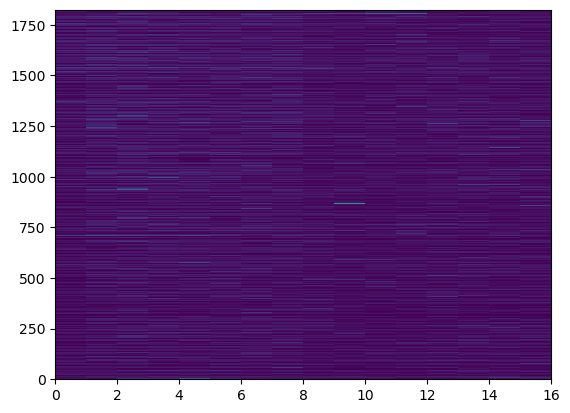

In [8]:
import matplotlib.pyplot as plt
plt.pcolormesh(df_aggregatee.values)

In [9]:
# convert index of df_aggregatee to DatetimeIndex
df_aggregatee.index = pd.to_datetime(df_aggregatee.index)

df_aggregatee.shape

(1825, 16)

In [10]:

# filter out holidays and weekends from df_aggregatee
df_aggregatee = df_aggregatee[~df_aggregatee.index.isin(pd.date_range('2013-01-01', '2017-12-31').difference(pd.bdate_range('2013-01-01', '2017-12-31')))]
df_aggregatee.shape

(1304, 16)

In [16]:
percent_ls = [0, 0.5, 1, 2, 2.5]
for percent in percent_ls:
    # 0.5: remove 0.0069
    # 1: remove 0.04677914110429448
    # 2: remove 0.09815950920245399
    # 2.5: remove 0.1280674846625767

    # if 2.5, then remove any row that contains 
    # at least one time interval whose count is 
    # less than 2.5% of quantile in that interval
    # or larger than 97.5% of quantile in that interval

    # compute quantile for each time interval
    count_mat = df_aggregatee.values
    before_count_mat = count_mat.copy()
    quantile = np.quantile(count_mat, [percent/100, 1-percent/100], axis=0)

    # remove rows that contain at least one time interval whose count is
    # less than 2.5% of quantile in that interval
    # or larger than 97.5% of quantile in that interval
    # plt.pcolormesh((before_count_mat >= quantile[0]) & (before_count_mat <= quantile[1]))
    n_outlier = np.zeros(before_count_mat.shape[0]) # number of outlier in each row
    for i in range(before_count_mat.shape[1]):
        n_outlier += (before_count_mat[:, i] < quantile[0, i]) | (before_count_mat[:, i] > quantile[1, i])

    to_remove = n_outlier > 1
    count_mat = count_mat[~to_remove]
    # count_mat = count_mat[(before_count_mat >= quantile[0]).all(axis=1) & (before_count_mat <= quantile[1]).all(axis=1)]

    print('Quantile:', percent)
    print('Number of rows removed: ', before_count_mat.shape[0] - count_mat.shape[0], 'out of', before_count_mat.shape[0])
    print('Percentage of rows removed:', (before_count_mat.shape[0] - count_mat.shape[0])/before_count_mat.shape[0])
    print('-----')
    np.save('callcenter/callcenter_{}.npy'.format(percent), count_mat)

Quantile: 0
Number of rows removed:  0 out of 1304
Percentage of rows removed: 0.0
-----
Quantile: 0.5
Number of rows removed:  9 out of 1304
Percentage of rows removed: 0.006901840490797546
-----
Quantile: 1
Number of rows removed:  61 out of 1304
Percentage of rows removed: 0.04677914110429448
-----
Quantile: 2
Number of rows removed:  128 out of 1304
Percentage of rows removed: 0.09815950920245399
-----
Quantile: 2.5
Number of rows removed:  167 out of 1304
Percentage of rows removed: 0.1280674846625767
-----
